In [2]:
import geopandas as gp
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

In [5]:
# define geojson 

filename = 'NASA/POWER_Point_Monthly_Timeseries_1981_2020_048d4093N_123d5716W_LST.json'

In [6]:
# read geojson with geopandas

df = gp.read_file(filename)
df.head()

,parameter,geometry
0,"{'ALLSKY_KT': {'198401': 0.43, '198402': 0.39,...",POINT Z (-123.57160 48.40930 211.36000)


In [7]:
# Convert geopandas to pandas DF

Idict = df['parameter'][0]

Idf =  pd.DataFrame.from_dict(Idict)
Idf

,ALLSKY_KT,CLOUD_AMT,CLRSKY_KT,TOA_SW_DWN,ALLSKY_SFC_UVA,ALLSKY_SFC_UVB,ALLSKY_SRF_ALB,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_PAR_TOT,ALLSKY_SFC_SW_DIFF,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UV_INDEX
198401,0.43,71.46,0.66,2.80,-999.00,-999.00,0.23,-999.00,1.20,1.85,-999.00,-999.00,-999.00,-999
198402,0.39,82.41,0.69,4.35,-999.00,-999.00,0.23,-999.00,1.71,2.99,-999.00,-999.00,-999.00,-999
198403,0.47,76.16,0.72,6.63,-999.00,-999.00,0.21,-999.00,3.13,4.76,-999.00,-999.00,-999.00,-999
198404,0.48,77.63,0.74,8.97,-999.00,-999.00,0.16,-999.00,4.30,6.69,-999.00,-999.00,-999.00,-999
198405,0.48,75.46,0.73,10.75,-999.00,-999.00,0.25,-999.00,5.23,7.82,-999.00,-999.00,-999.00,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202009,0.52,47.92,0.63,7.34,8.49,0.16,0.09,4.80,3.77,4.63,69.04,1.34,84.33,-999
202010,0.45,68.50,0.68,5.01,5.15,0.09,0.10,3.01,2.21,3.41,40.66,1.05,62.92,-999
202011,0.37,79.25,0.66,3.17,2.64,0.02,0.09,1.91,1.17,2.10,20.93,0.62,37.69,-999
202012,0.35,79.65,0.63,2.37,1.81,0.01,0.09,1.65,0.84,1.51,14.81,0.44,26.85,-999


In [8]:
# Creating a df for modelling solar index from the original df

Prophetdf = pd.DataFrame(Idf['ALLSKY_KT'])
type(Prophetdf)
Prophetdf

,ALLSKY_KT
198401,0.43
198402,0.39
198403,0.47
198404,0.48
198405,0.48
...,...
202009,0.52
202010,0.45
202011,0.37
202012,0.35


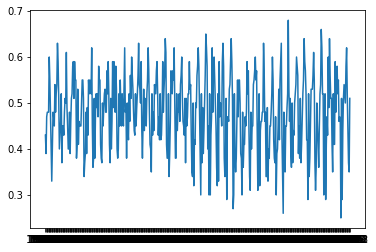

In [9]:
plt.plot(Prophetdf['ALLSKY_KT'][:])

In [11]:
# removing the annual average from the df and resetting the time stamp to year/month

Prophetdf.index[12::13]

Prophetdf=Prophetdf.rename(columns={"ALLSKY_KT": "y"})


def append(dfseries):
    dfseries = dfseries[:4] + '/' + dfseries[4:]
    return dfseries
print(Prophetdf.index[12::13])
print(Prophetdf.shape)
Prophetdf = Prophetdf.drop(Prophetdf.index[12::13])
print(Prophetdf.shape)
Prophetdf['ds']=Prophetdf.index
Prophetdf['ds']= Prophetdf['ds'].astype(str)

Prophetdf['ds'] = Prophetdf['ds'].apply(append)
#a_string = a_string[:1] + "b" + a_string[1:]
Prophetdf

Index(['198413', '198513', '198613', '198713', '198813', '198913', '199013',
       '199113', '199213', '199313', '199413', '199513', '199613', '199713',
       '199813', '199913', '200013', '200113', '200213', '200313', '200413',
       '200513', '200613', '200713', '200813', '200913', '201013', '201113',
       '201213', '201313', '201413', '201513', '201613', '201713', '201813',
       '201913', '202013'],
      dtype='object')
(481, 1)
(444, 1)


,y,ds
198401,0.43,1984/01
198402,0.39,1984/02
198403,0.47,1984/03
198404,0.48,1984/04
198405,0.48,1984/05
...,...,...
202008,0.62,2020/08
202009,0.52,2020/09
202010,0.45,2020/10
202011,0.37,2020/11


## Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.14409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       968.167     0.0132679       58.1514           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       968.315   0.000416937       80.8622   5.958e-06       0.001      196  LS failed, Hessian reset 
     195        968.42   0.000297427       77.9913   2.988e-06       0.001      334  LS failed, Hessian reset 
     199       968.429   3.78646e-05        55.912      0.6905      0.6905      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       968.439   6.22059e-08       62.4679           1           1      436   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


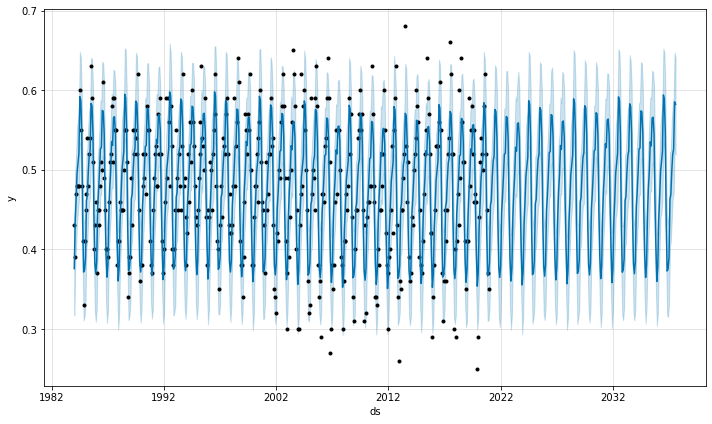

In [19]:
# setting model parameters to seasonality_mode='multiplicative'

m = Prophet(seasonality_mode='multiplicative')
m.fit(Prophetdf)

# predicting part

future = m.make_future_dataframe(200, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)

Even with seasonality mode set to multiplicative, the model doesn't seem to acknowledge the increasing range of index numbers in the dataset. The ``plot_components`` function gives some background on the components of the forecast below: 

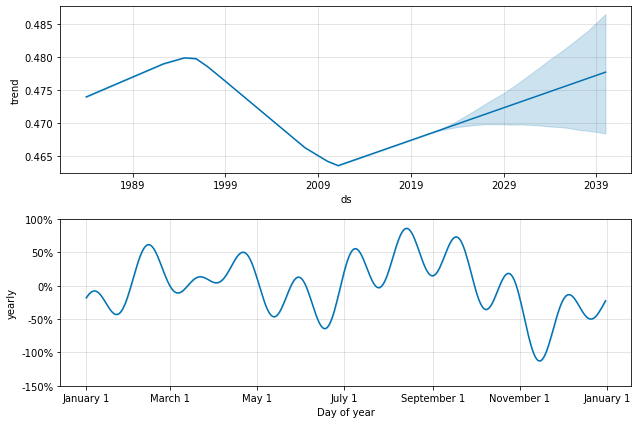

In [17]:
fig = m.plot_components(forecast)

evidently, the trend confidence interval gets progressively worse with time. 

I did some soul searching on the prophet website and it's possible we need different args in the actual model. The code below I copied from an example on the [page](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html) and it looks...interesting. I don't know what all the arguments mean, but the confidence interval is suspiciously good?

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.14409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       983.346   0.000558226       106.202           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       984.334   0.000141666       83.7018           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       984.397   0.000235737       78.3049      0.3422           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       984.545   0.000707611       82.3102           1           1      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     470       984.584   1.17505e-05       78.4718    1.44e-07       0.001      602  LS failed, Hessian reset 
     499       984.585   7.90662e-07    

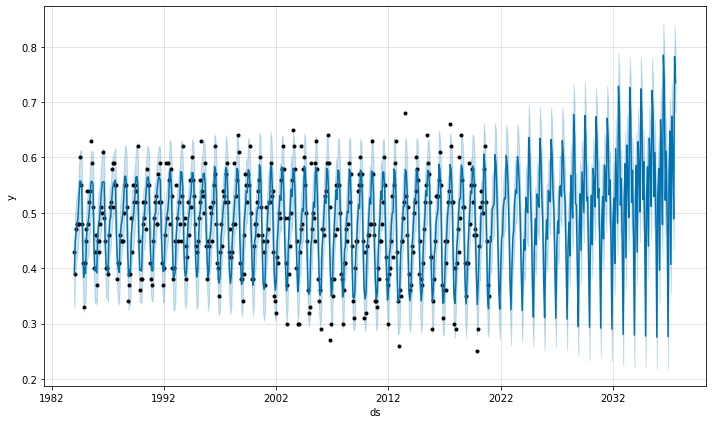

In [22]:
m = Prophet(seasonality_mode='multiplicative')
m.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
m.fit(Prophetdf)

future = m.make_future_dataframe(200, freq='MS')
forecast = m.predict(future)
fig = m.plot(forecast)


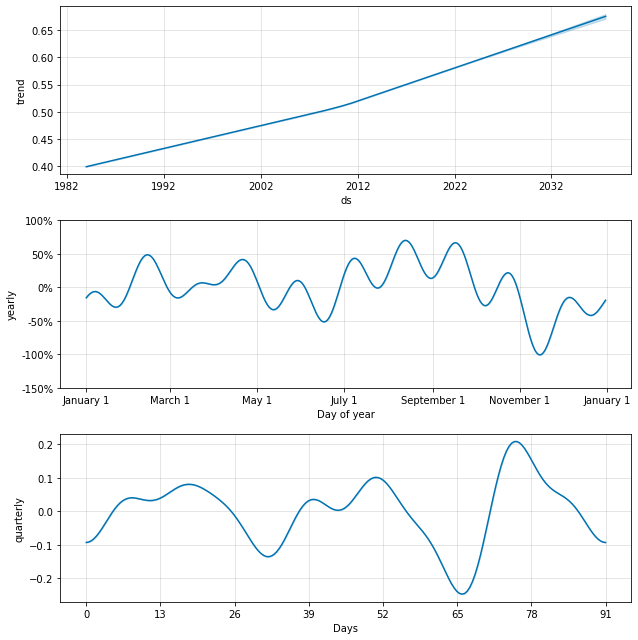

In [23]:
fig = m.plot_components(forecast)

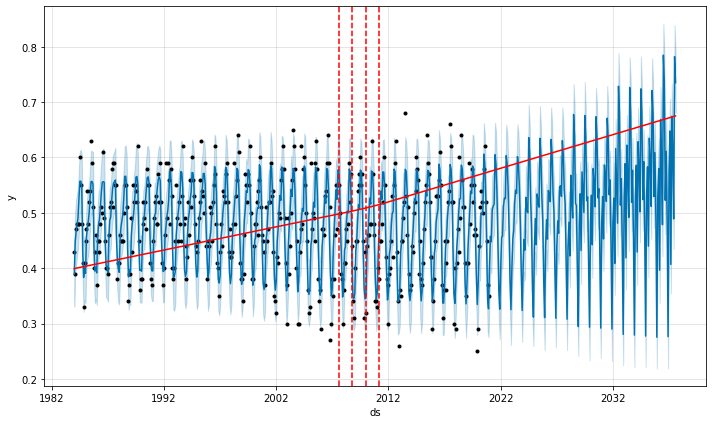

In [24]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


### Trying annual data instead

In [25]:
Idf.head()


,ALLSKY_KT,CLOUD_AMT,CLRSKY_KT,TOA_SW_DWN,ALLSKY_SFC_UVA,ALLSKY_SFC_UVB,ALLSKY_SRF_ALB,ALLSKY_SFC_SW_DNI,ALLSKY_SFC_SW_DWN,CLRSKY_SFC_SW_DWN,ALLSKY_SFC_PAR_TOT,ALLSKY_SFC_SW_DIFF,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_UV_INDEX
198401,0.43,71.46,0.66,2.80,-999.0,-999.0,0.23,-999.0,1.20,1.85,-999.0,-999.0,-999.0,-999
198402,0.39,82.41,0.69,4.35,-999.0,-999.0,0.23,-999.0,1.71,2.99,-999.0,-999.0,-999.0,-999
198403,0.47,76.16,0.72,6.63,-999.0,-999.0,0.21,-999.0,3.13,4.76,-999.0,-999.0,-999.0,-999
198404,0.48,77.63,0.74,8.97,-999.0,-999.0,0.16,-999.0,4.30,6.69,-999.0,-999.0,-999.0,-999
198405,0.48,75.46,0.73,10.75,-999.0,-999.0,0.25,-999.0,5.23,7.82,-999.0,-999.0,-999.0,-999


In [26]:
anndf = pd.DataFrame(Idf['ALLSKY_KT'])


In [31]:
anndf2 = anndf.loc[anndf.index[12::13]]
anndf2

,ALLSKY_KT
198413,0.48
198513,0.52
198613,0.48
198713,0.53
198813,0.48
198913,0.51
199013,0.50
199113,0.51
199213,0.52
199313,0.50


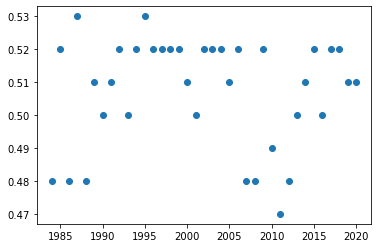

In [45]:
#Prophetdf.index[12::13]
# renaming first column

model_ann = anndf2.rename(columns={"ALLSKY_KT": "y"})


def append(dfseries):
    dfseries = dfseries[:4] #+ '/' + dfseries[4:]
    return dfseries

model_ann['ds']=model_ann.index
model_ann['ds']= model_ann['ds'].astype(str)

model_ann['ds'] = model_ann['ds'].apply(append)
#a_string = a_string[:1] + "b" + a_string[1:]
#model_ann
plt.scatter(x = model_ann['ds'].values.astype(int), y=model_ann['y'].values)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -48.1988
Iteration  1. Log joint probability =    47.1514. Improved by 95.3502.
Iteration  2. Log joint probability =    92.8451. Improved by 45.6937.
Iteration  3. Log joint probability =    108.401. Improved by 15.556.
Iteration  4. Log joint probability =    108.404. Improved by 0.00245726.
Iteration  5. Log joint probability =    108.432. Improved by 0.0287554.
Iteration  6. Log joint probability =     108.45. Improved by 0.0171609.
Iteration  7. Log joint probability =     108.45. Improved by 0.000708313.
Iteration  8. Log joint probability =    108.551. Improved by 0.100661.
Iteration  9. Log joint probability =    108.611. Improved by 0.0598597.
Iteration 10. Log joint probability =    108.758. Improved by 0.147187.
Iteration 11. Log joint probability =    110.022. Improved by 1.26401.
Iteration 12. Log joint probability =    110.096. Improved by 0.074317.
Iteration 13. Log joint probability =    110.107. Improved by 0.0107331.
Iteration 14. Log 

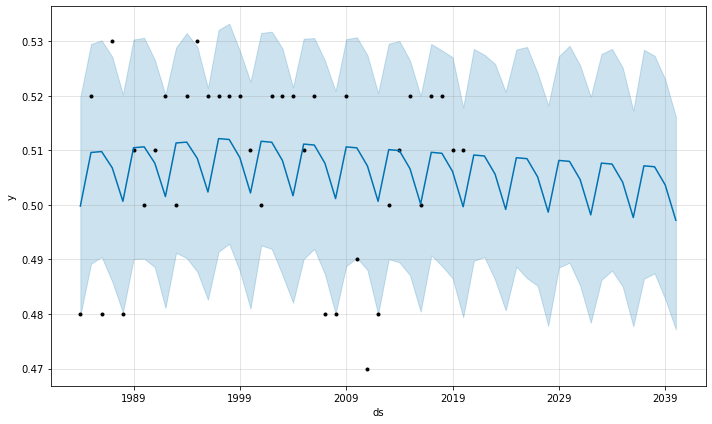

In [52]:
z = Prophet()
z.fit(model_ann);

future = z.make_future_dataframe(20, freq='YS')
forecast = z.predict(future)
fig = z.plot(forecast)